In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Text(0,0.5,u'$y$')

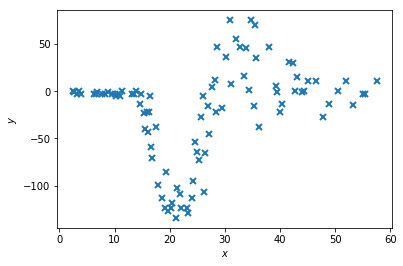

In [2]:
data = np.loadtxt('../data/motor.dat')
X = data[:, 0][:, None]
Xm = np.mean(X)
Xv = np.std(X)
Xnorm = (X - Xm)/Xv
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [3]:
#build the model
k1 = hetero_kernels.RBF(1)
k2 = hetero_kernels.RBF(1)
m = hetero_gpmc.GPMCHeteroNoiseRegression(Xnorm, Y[:,None], k1, k2)

In [4]:
m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern1.variance.prior = gpflow.priors.Gamma(3.,3.)

m.kern2.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
#m.kern2.variance.prior = gpflow.priors.Gamma(1.,1.)

m.kern2.variance = .1
m.kern2.variance.fixed = True

In [5]:
m.optimize(maxiter=1000) # start near MAP
samples = m.sample(3000, verbose=True, epsilon=0.01, thin = 2, burn = 500, Lmax = 20)

burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  98.0 %
Iteration:  300 	 Acc Rate:  99.0 %
Iteration:  400 	 Acc Rate:  99.0 %
Iteration:  500 	 Acc Rate:  100.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  98.0 %
Iteration:  300 	 Acc Rate:  99.0 %
Iteration:  400 	 Acc Rate:  98.0 %
Iteration:  500 	 Acc Rate:  100.0 %
Iteration:  600 	 Acc Rate:  98.0 %
Iteration:  700 	 Acc Rate:  99.0 %
Iteration:  800 	 Acc Rate:  100.0 %
Iteration:  900 	 Acc Rate:  98.0 %
Iteration:  1000 	 Acc Rate:  100.0 %
Iteration:  1100 	 Acc Rate:  100.0 %
Iteration:  1200 	 Acc Rate:  100.0 %
Iteration:  1300 	 Acc Rate:  99.0 %
Iteration:  1400 	 Acc Rate:  100.0 %
Iteration:  1500 	 Acc Rate:  98.0 %
Iteration:  1600 	 Acc Rate:  100.0 %
Iteration:  1700 	 Acc Rate:  100.0 %
Iteration:  1800 	 Acc Rate:  100.0 %
Iteration:  1900 	 Acc Rate:  99.0 %
Iteration:  2000 	 Acc Rate:  99.0 %
Iteration:  2100 	 Acc Rate:  9

In [6]:
m

Name,values,prior,constraint
hetero_noise_regression_model.V1,[[-0.07083726] [-0.20583094] [ 0.06158749] [-0.07958483] [-0.21412199] [-0.2498866 ] [-0.05526334] [ 0.24082641] [ 0.26223875] [ 0.35708087] [ 0.06442986] [-0.24510782] [-0.77855829] [-0.64867463] [-1.11133755] [-1.44051225] [-1.66585529] [-3.27964515] [-3.61622102] [-2.36363 ] [-3.18970404] [-2.39907497] [-2.50439084] [-1.91714932] [-1.58603228] [-1.25794898] [-1.2757824 ] [-1.34975162] [-1.30152256] [-1.16424397] [-1.68161185] [-1.21080712] [-1.27421839] [-1.06387464] [-0.44197816] [-0.39215762] [-0.39743922] [-0.15717779] [-0.09208972] [ 0.12348389] [ 0.17026899] [ 0.20209469] [ 0.54093419] [ 0.61543581] [ 0.55003945] [ 0.60951452] [ 0.60993516] [ 0.60761625] [ 0.67340266] [ 0.45143746] [ 0.58707065] [ 0.42135947] [ 0.45577867] [ 0.60725315] [ 0.41577004] [ 0.48191355] [ 0.47352381] [ 0.30456253] [ 0.26024223] [ 0.32558781] [ 0.27217452] [ 0.13621907] [ 0.03633349] [ 0.02027866] [-0.00837181] [ 0.01863051] [ 0.06141047] [ 0.11514409] [ 0.18004048] [ 0.19768931] [ 0.17659418] [ 0.19517984] [ 0.29349282] [ 0.43418488] [ 0.26509553] [-0.06799604] [-0.16978482] [-0.33897361] [-0.40859533] [-0.4590144 ] [-0.2503092 ] [-0.07112397] [-0.02758849] [ 0.11026172] [ 0.13415683] [ 0.11630472] [-0.18182643] [-0.46622011] [-0.31647066] [ 0.33134835] [ 0.79316422] [ 0.72951268] [ 0.3038894 ] [ 0.09280327]],"N([ 0.],[ 1.])",(none)
hetero_noise_regression_model.V2,[[ 2.54114330e+00] [ 5.70803305e+00] [ 2.65166316e+00] [ 1.40207749e+00] [ 1.93480686e+00] [ 5.12140002e+00] [ 1.32547719e+00] [ 1.01604765e+00] [ 2.22712226e+00] [ 1.38354080e+00] [ 1.45923501e+00] [ 1.69767833e+00] [ 1.26551590e+00] [ 9.50456502e-01] [ 1.11403993e+00] [ 1.19744263e+00] [ 1.20485009e+00] [ 2.14069770e+00] [ 8.81848465e-01] [ 5.90875301e-01] [ 9.10736425e-01] [ 6.42746889e-01] [ 8.11371365e-01] [ 6.21185577e-01] [ 5.42670503e-01] [ 5.09330322e-01] [ 4.95852793e-01] [ 4.96133571e-01] [ 4.86166287e-01] [ 4.86506699e-01] [ 8.19590837e-01] [ 6.06384516e-01] [ 7.77313595e-01] [ 6.90325572e-01] [ 4.68355156e-01] [ 3.88309871e-01] [ 5.03225975e-01] [ 4.03053786e-01] [ 5.78609876e-01] [ 4.14472113e-01] [ 4.11970140e-01] [ 3.42184437e-01] [ 6.07539364e-01] [ 3.71396206e-01] [ 3.90096806e-01] [ 2.88784670e-01] [ 2.94948294e-01] [ 2.98119648e-01] [ 2.98526705e-01] [ 2.49448116e-01] [ 2.69963800e-01] [ 2.37253502e-01] [ 2.10934576e-01] [ 2.81165841e-01] [ 2.31264395e-01] [ 2.40215333e-01] [ 2.73552356e-01] [ 2.09204931e-01] [ 1.79322215e-01] [ 2.47310989e-01] [ 2.61638209e-01] [ 2.43678623e-01] [ 1.51304958e-01] [ 1.82084490e-01] [ 1.84324752e-01] [ 1.55681181e-01] [ 1.24510813e-01] [ 1.26089704e-01] [ 1.10542997e-01] [ 9.72804109e-02] [ 7.96073183e-02] [ 6.60455439e-02] [ 8.83363810e-02] [ 1.41923174e-01] [ 9.19466578e-02] [ 4.51208657e-02] [ 4.56930554e-02] [ 3.80501944e-02] [ 5.34781868e-02] [ 4.14726496e-02] [ 2.62227733e-02] [ 1.85976057e-02] [ 2.41918607e-02] [ 1.72486304e-02] [ 1.55062483e-02] [ 1.75436877e-02] [ 1.09044051e-02] [ 1.75387160e-03] [ -5.04518847e-04] [ 7.48450143e-04] [ -3.33916941e-03] [ -5.66087345e-03] [ -1.97853763e-03] [ -9.75007079e-04]],"N([ 0.],[ 1.])",(none)
hetero_noise_regression_model.kern1.lengthscales,[ 0.24563116],"Ga([ 1.],[ 1.])",+ve
hetero_noise_regression_model.kern1.variance,[ 138.77474163],"Ga([ 3.],[ 3.])",+ve
hetero_noise_regression_model.kern2.lengthscales,[ 1.33994623],"Ga([ 1.],[ 1.])",+ve
hetero_noise_regression_model.kern2.variance,[ 0.1],None,[FIXED]


In [7]:
xnew = np.linspace(0,60,50)[:,None]
xx = (xnew - Xm)/Xv
meanmat1 = np.zeros(shape = (samples.shape[0], xx.shape[0]))
varmat1 = np.zeros(shape = (samples.shape[0], xx.shape[0]))
meanmat2 = np.zeros(shape = (samples.shape[0], xx.shape[0]))
varmat2 = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [8]:
sample_df = m.get_samples_df(samples)

In [9]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_f(xx)
    var1 = v1[:,:]
    meanmat1[i,:] = mean1[:,0]
    varmat1[i,:] = np.diag(var1)
    mean2, v2 = m.predict_n(xx)
    var2 = v2[:,:]
    meanmat2[i,:] = mean2[:,0]
    varmat2[i,:] = np.diag(var2)

In [10]:
m1 = meanmat1[0,:]
v1 = varmat1[0,:]
std1 = np.sqrt(v1)
m2 = meanmat2[0,:]
v2 = varmat2[0,:]
std2 = np.sqrt(v2)

In [22]:
def visualize(Xgrid, M1, V1, M2, V2):
    """
    Visualize
    """
    Std1 = np.sqrt(V1)
    Std2 = np.sqrt(V2)
    
    L1 = M1 - 2*Std1
    U1 = M1 + 2*Std1
    
    
    N = M2 + 2*Std2
    Nexp = np.exp(N)
    
    L2 = L1 - 2*Nexp
    U2 = U1 + 2*Nexp
    
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, M1, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L1, U1,
                     color = 'b', alpha = 0.25)
    plt.fill_between(Xgrid[:,0], L2, U2,
                     color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

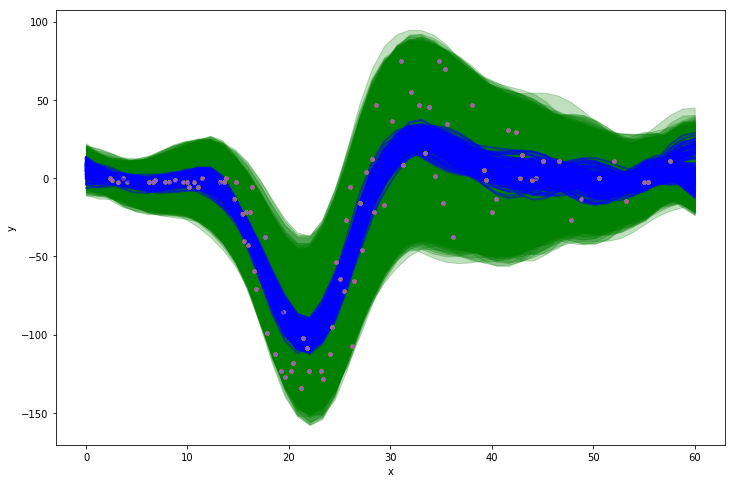

In [23]:
mini = 205
maxi = 400
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, meanmat1[i,:], varmat1[i,:], meanmat2[i,:], varmat2[i,:])

In [13]:
# Data generation scheme (posterior predictive distribution)
S1 = np.random.normal(m1, std1)
S2 = np.random.normal(m2, std2)
S2exp = np.exp(S2)

P = np.random.normal(S1, S2exp)

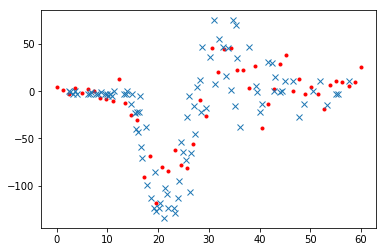

In [14]:
plt.plot(xnew, P, '.', color = 'r')
plt.plot(X, Y, 'x')

In [15]:
mean_n_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_n_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [16]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_n(xx)
    var1 = v1[:,:]
    mean_n_mat[i,:] = mean1[:,0]
    var_n_mat[i,:] = np.diag(var1)

std_n_mat = np.sqrt(var_n_mat)

In [17]:
LowerlogN = mean_n_mat - 2*std_n_mat
UpperlogN = mean_n_mat + 2*std_n_mat

In [18]:
MeanN = np.exp(mean_n_mat)
LowerN = np.exp(LowerlogN)
UpperN = np.exp(UpperlogN)

In [19]:
def visualize(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

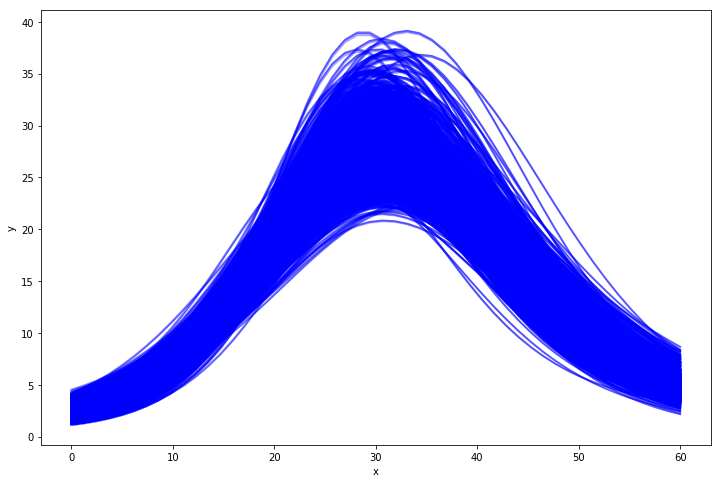

In [20]:
mini = 405
maxi = 1510
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, MeanN[i,:], LowerN[i,:], UpperN[i,:])  